[1. What was the impact from implementing Intellicron?](#question1)

[2. How certain are you of these results? Do you have enough data?](#question2)

[3. Do you have any concerns about the split test’s implementation? Is there anything you would do differently next time?](#question3)

[4. Should we implement Intellicron? What other data, if any, would you need to make this determination?](#question4)

In [1]:
#First things first, let's import pandas, read the two csvs, and do some quick data reformatting.
import pandas as pd
import sys
sys.path.append('Product_Analyst_Case_Study')

# read in prequals
df1 = pd.read_csv('Product_Analyst_Case_Study/prequals.csv')
df1['completed_checkout'] = df1.checkout_id.notnull().apply(lambda x: 1 if x else 0)

# read in intellicron_prequals and merge with prequals df
dat2 = pd.read_csv('Product_Analyst_Case_Study/intellicron_prequals.csv')
df2 = dat2.merge(df1, how='left', on='prequal_id')


In [2]:
# looking at df1
df1.describe()

,Unnamed: 0,completed_prequal,approved,completed_checkout
count,199751.000000,199751.000000,199751.000000,199751.000000
mean,99876.000000,0.539256,0.361170,0.278447
std,57663.291148,0.498458,0.480341,0.448236
min,1.000000,0.000000,0.000000,0.000000
25%,49938.500000,0.000000,0.000000,0.000000
50%,99876.000000,1.000000,0.000000,0.000000
75%,149813.500000,1.000000,1.000000,1.000000
max,199751.000000,1.000000,1.000000,1.000000


In [3]:
# looking at df2
df2.describe()

,Unnamed: 0_x,Unnamed: 0_y,completed_prequal,approved,completed_checkout
count,9591.00000,9591.000000,9591.000000,9591.000000,9591.000000
mean,4796.00000,140974.888333,0.595558,0.420915,0.342613
std,2768.82755,72617.004506,0.490809,0.493732,0.474608
min,1.00000,143.000000,0.000000,0.000000,0.000000
25%,2398.50000,32735.500000,0.000000,0.000000,0.000000
50%,4796.00000,183262.000000,1.000000,0.000000,0.000000
75%,7193.50000,192739.500000,1.000000,1.000000,1.000000
max,9591.00000,199694.000000,1.000000,1.000000,1.000000


In [4]:
# because of the large discrepancy in index size of the two dataframes, I want to double check the dates
print(df1.prequal_date.min(),df1.prequal_date.max())
print(df2.prequal_date.min(),df2.prequal_date.max())

2017-12-31 2018-06-30
2018-06-16 2018-06-30


In [5]:
#...sneaky sneaks included extra data from before testing period

# So now we know that the dataset contains more than just the test period. Let's find the control group and test group
# by filtering for prequal_ids sent to intellicron and for dates during our testing period defined as the 
# min and max date that the intellicron api was called

intellicron_users = df2.prequal_id.tolist()

i_df = df1[df1.prequal_id.isin(intellicron_users)].reset_index(drop=True)
test_start = i_df.prequal_date.min()
test_end = i_df.prequal_date.max()

control_df = df1[(df1.prequal_id.isin(intellicron_users)==False) & 
                (df1.prequal_date>=test_start) &
                (df1.prequal_date<=test_end)].reset_index(drop=True)

In [6]:
# check the number of observations in each
print(control_df.index.size, i_df.index.size)

10689 9591


In [7]:
# compare the test group to the control group to look for any inconsistencies, patterns
control_df.groupby('prequal_date').count()-i_df.groupby('prequal_date').count()

,Unnamed: 0,prequal_id,checkout_id,completed_prequal,approved,completed_checkout
prequal_date,,,,,,
2018-06-16,84,84,6,84,84,84
2018-06-17,100,100,-24,100,100,100
2018-06-18,116,116,75,116,116,116
2018-06-19,121,121,22,121,121,121
2018-06-20,100,100,29,100,100,100
2018-06-21,35,35,1,35,35,35
2018-06-22,53,53,14,53,53,53
2018-06-23,25,25,2,25,25,25
2018-06-24,73,73,11,73,73,73


In [8]:
# What is the average percent difference in observations in each category?
((control_df.groupby('prequal_date').count()-i_df.groupby('prequal_date').count())/
(control_df.groupby('prequal_date')).count()).mean()

Unnamed: 0            0.102211
prequal_id            0.102211
checkout_id           0.050366
completed_prequal     0.102211
approved              0.102211
completed_checkout    0.102211
dtype: float64

<a id='question1'></a>
### Question 1
What was the impact from implementing Intellicron?

In [9]:
# because these vectors are binomial distributions, I can take the mean as a probability
print('Intellicron checkout conversion rate = %s'%i_df.completed_checkout.mean())
print('Intellicron approval rate = %s'%i_df.approved.mean())
print('Intellicron completed prequal rate = %s'%i_df.completed_prequal.mean())

print('Control group checkout conversion rate = %s'%control_df.completed_checkout.mean())
print('Control approval rate = %s'%control_df.approved.mean())
print('Control completed prequal rate = %s'%control_df.completed_prequal.mean())

Intellicron checkout conversion rate = 0.34261286622875614
Intellicron approval rate = 0.42091544155979566
Intellicron completed prequal rate = 0.5955583359399437
Control group checkout conversion rate = 0.32500701655907943
Control approval rate = 0.3965759191692394
Control completed prequal rate = 0.5584245486013659


In [10]:
print(('Using Intellicron appears to have resulted in a {0} absolute change in the Application Step, ' + 
       'and a {1} relative change').format(
                                    i_df.completed_prequal.mean()-control_df.completed_prequal.mean(),
                                    (i_df.completed_prequal.mean()-control_df.completed_prequal.mean())/control_df.completed_prequal.mean()
                                    ))

Using Intellicron appears to have resulted in a 0.03713378733857775 absolute change in the Application Step, and a 0.06649741210622509 relative change


<a id='question2'></a>
### Question 2
2. How certain are you of these results? Do you have enough data?

Restating this question a bit, can we be confident that the differences between the Intellicron customers and the control customers are statistically significant?

In [11]:
# let's perform a two sample z test to test the means of the binomial distribution of the control group and the 
# test group. The null hypothesis is that the mean of the control equals the mean of the test group

from statsmodels.stats.weightstats import ztest

print(ztest(i_df.completed_checkout,control_df.completed_checkout))
print(ztest(i_df.approved,control_df.approved))
print(ztest(i_df.completed_prequal,control_df.completed_prequal))

(2.6557295857797354, 0.007913704456696072)
(3.521961879675138, 0.00042836573565700325)
(5.345940575289408, 8.99487177832141e-08)


For all three of the above it appears that we can reject the null hypothesis at the 1 % significance level.

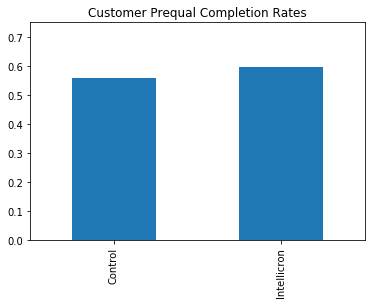

In [12]:
# adding some charts for the presentation
%matplotlib inline

dat = {'Control':control_df.completed_prequal.mean(),
      'Intellicron':i_df.completed_prequal.mean()}
df_bar = pd.DataFrame(data=dat,index=[0]).T
df_bar.plot(kind='bar',title='Customer Prequal Completion Rates',ylim=[0,.75],legend=False)

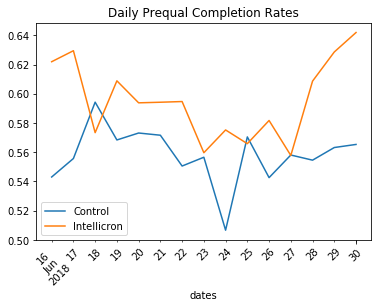

In [13]:
# because I can fairly easily get daily completed prequal rates
df_plot = pd.DataFrame(data={
    'Control':control_df.groupby('prequal_date')['completed_prequal'].mean(),
    'Intellicron':i_df.groupby('prequal_date')['completed_prequal'].mean()
}).reset_index()
df_plot['dates'] = df_plot.prequal_date.apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d'))
df_plot.plot(x='dates',y=['Control','Intellicron'],
             title='Daily Prequal Completion Rates', rot=45)